In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import random
from statsmodels.stats.power import tt_ind_solve_power

def date_converter(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

Срок выполнения задания: 17 марта 17:00.


### Задание
Вам предстоит разработать дизайн эксперимента по тестированию монетизационных продуктов.
В конечном счёте, в монтизационных продуктах нас всегда интересует увеличение выручки, 
но к сожалению не всегда мы можем зафиксировать изменение именно этой метрики.

#### Кейс
Вы аналитик в продуктовой дискавери команде.
На текущий момент приближается начало нового квартала и вам необходимо спланировать
эксперименты в нём.

У вас есть два продукта:
- один базовый продукт, который предоставляет минимальный набор услуг на вашем ресурсе;
- один продвинутый продукт, который предоставляет расширенный набор услуг.

На текущий момент на квартал у вашей команды есть для проверки две гипотезы:
- Дополнительное информирование об эффективности услуг будет стимулировать их покупку;
- Повышение цены базового продукта должно стимулировать покупку продвинутого продукта


#### Для планирования эксперимента изучите данные и метрики (2 балла):

- Загрузите файл и изучите данные;
- Подумайте над тем, какие метрики можно выделить на основе этих данных: выручка, пользователи, транзакции, средний чек и т.д.
- Постройте графики плотности распределения для этих метрик и сделайте выводы о характере распределений: тип, наличие выбросов, насколько сильный разброс;
- Изучите основные статистики этих метрик: среднее, стандартное отклонение;
- Изучите то, насколько эти статистики подвержены сезональности.


#### Формализуйте гипотезы (4 балла):

- Опишите метрики и статистики, изменение которых вы ожидаете;
- Предположите какое относительное изменение этих статистик в процентах вы ожидаете.

#### Предскажите минимально детектируемый эффект для своих метрик и спланируйте эксперименты внутри квартала (4 балла):

- Принимая в расчёт максимально возможные размеры групп и ограничения по длительности в квартал рассмотрите разные планы проведения тестов и предскажите их чувствительность;
- Определите наиболее оптимальный план экспериментов. Обоснуйте, почему вы его считаете оптимальным.


#### * Оптимизация плана (2 балла):
Предложите варианты ускорения экспериментов — всегда могут образоваться ситуации, когда ваши гипотезы не подтвердились и они требуют изменения или уточнения и необходимости повторных тестов. Цели достигать всегда хорошо в рамках отведённого на них срока. Какие параметры экспериментов вы поменяете? К каким последствиям могут привести такие изменения?

#### Описание данныx

event_date - дата 

user_id - идентификатор пользователя

product - тип продукта

amount - сумма покупок

transactions - количество транзакций


In [33]:
df = pd.read_csv('user_transactions.csv')
df['event_date']=df.event_date.apply(date_converter)

In [6]:
df.user_id.nunique() #кол-во пользователей в выгрузке

446935

In [7]:
df.shape[0] #кол-во записей

1278186

In [8]:
print(df.event_date.nunique())
df.event_date.min(), df.event_date.max() #наблюдения за 3 месяца на каждый день (92 дня)
#Но не по всем пользователям наблюдения на каждый день

92


(Timestamp('2020-09-29 00:00:00'), Timestamp('2020-12-29 00:00:00'))

In [27]:
df[df['user_id'] == 1809139296429]

,event_date,user_id,product,amount,transactions
478785,2020-11-19,1809139296429,advanced,980.0,1


In [29]:
df[df['user_id'] == 23708868092799].sort_values(by='event_date')

,event_date,user_id,product,amount,transactions
91193,2020-10-06,23708868092799,basic,79.0,1
261880,2020-10-21,23708868092799,basic,69.0,1
308221,2020-10-26,23708868092799,basic,69.0,1
642217,2020-11-09,23708868092799,basic,69.0,1
651381,2020-11-20,23708868092799,basic,69.0,1
611895,2020-11-23,23708868092799,basic,69.0,1
609051,2020-11-26,23708868092799,basic,69.0,1
793382,2020-11-27,23708868092799,basic,69.0,1
1217456,2020-11-30,23708868092799,basic,49.0,1
598823,2020-12-01,23708868092799,basic,69.0,1


### Метрики

**Дополнительное информирование об эффективности услуг будет стимулировать их покупку:**
- кол-во транзакций на юзера за неделю (далее увидим, что у метрики недельная сезонность, берем неделю, чтобы убрать сезонность)  - ожидаю повышение
- кол-во уникальных платящих пользователей за неделю - ожидаю повышение
- ARPPU недельный- ожидаю повышение

**Повышение цены базового продукта должно стимулировать покупку продвинутого продукта:**
- доля платящих в тарифе advanced - повышение
- доля платящих в тарифе basic - понижение
- ARPPU недельный- повышение

In [97]:
df['week_num'] = df['event_date'].dt.week

C:\Users\Diana\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """Entry point for launching an IPython kernel.


Сначала посмотрим на сезональность метрик - видим, что у всех метрик ярковыраженная недельная сезонность

In [234]:
basic_1 = df[df['product']=='basic'].groupby(by='event_date').sum()[['amount', 'transactions']].reset_index()
basic_1.columns = ['event_date','basic_amount', 'basic_tr']

basic_2 = df[df['product']=='basic'].groupby(by='event_date').count()[['user_id']].reset_index()
basic_2.columns = ['event_date','basic_users']

basic = pd.merge(basic_1, basic_2, how='inner', on='event_date')

adv_1 = df[df['product']=='advanced'].groupby(by='event_date').sum()[['amount', 'transactions']].reset_index()
adv_1.columns = ['event_date','adv_amount', 'adv_tr']

adv_2 = df[df['product']=='advanced'].groupby(by='event_date').count()[['user_id']].reset_index()
adv_2.columns = ['event_date','adv_users']

adv = pd.merge(adv_1, adv_2, how='inner', on='event_date')

sums_by_date = pd.DataFrame(df.groupby(by = 'event_date').sum()[['transactions', 'amount']]).reset_index()
cnt_by_date = pd.DataFrame(df.groupby(by = 'event_date')['user_id'].nunique()).reset_index()

full_aggr_df = pd.merge(sums_by_date, cnt_by_date, how = 'inner', on = 'event_date')
full_aggr_df['avg_transaction'] = full_aggr_df['amount']/full_aggr_df['transactions']
full_aggr_df['arppu'] = full_aggr_df['amount']/full_aggr_df['user_id']

full_aggr_df = pd.merge(sums_by_date, cnt_by_date, how = 'inner', on = 'event_date')
full_aggr_df = pd.merge(full_aggr_df, basic, how = 'inner', on = 'event_date')
full_aggr_df = pd.merge(full_aggr_df, adv, how = 'inner', on = 'event_date')

full_aggr_df['adv_share'] = full_aggr_df['adv_users']/full_aggr_df['user_id']
full_aggr_df['basic_share'] = full_aggr_df['basic_users']/full_aggr_df['user_id']

#full_aggr_df['arppu'] = full_aggr_df['amount']/full_aggr_df['user_id']
full_aggr_df.head()

,event_date,transactions,amount,user_id,basic_amount,basic_tr,basic_users,adv_amount,adv_tr,adv_users,adv_share,basic_share,arppu
0,2020-09-29,16218.0,3033740.0,12802,1636824.0,12559.0,9953,1396916.0,3659.0,2967,0.231761,0.777457,236.973910
1,2020-09-30,17474.0,3254915.0,13586,1766349.0,13564.0,10616,1488566.0,3910.0,3106,0.228618,0.781393,239.578610
2,2020-10-01,16548.0,3055656.0,12866,1657642.0,12871.0,10100,1398014.0,3677.0,2896,0.225089,0.785015,237.498523
3,2020-10-02,17771.0,3194532.0,13228,1821303.0,14100.0,10467,1373229.0,3671.0,2897,0.219005,0.791276,241.497732
4,2020-10-03,14182.0,2450722.0,11164,1387349.0,11208.0,8822,1063373.0,2974.0,2440,0.218560,0.790219,219.520064


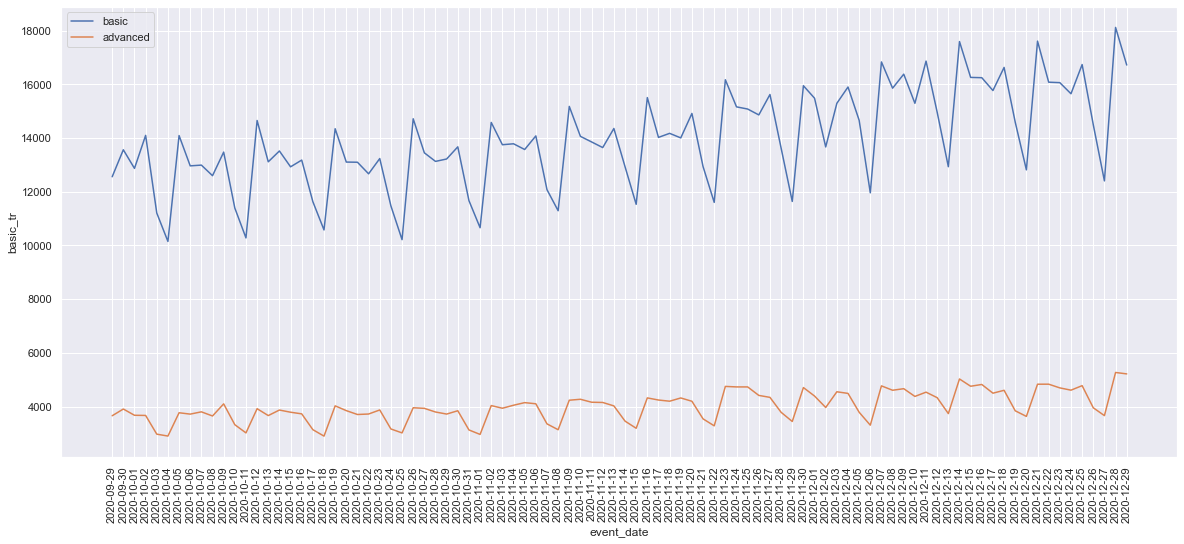

In [232]:
sns.set(rc={'figure.figsize':(20,8.27)})
#sns.lineplot(x='event_date', y='transactions', data = full_aggr_df, label='total')
sns.lineplot(x='event_date', y='basic_tr', data = full_aggr_df, label = 'basic')
sns.lineplot(x='event_date', y='adv_tr', data = full_aggr_df, label='advanced')
plt.xticks(tr_by_date['event_date'], rotation = 90)
plt.legend()
plt.show()

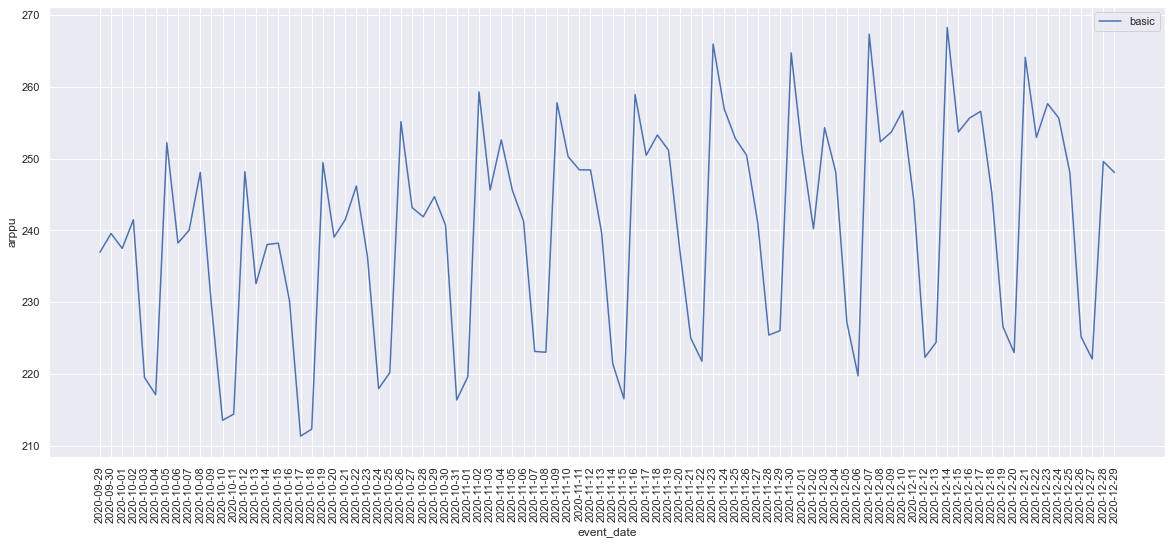

In [235]:
sns.set(rc={'figure.figsize':(20,8.27)})
#sns.lineplot(x='event_date', y='transactions', data = full_aggr_df, label='total')
sns.lineplot(x='event_date', y='arppu', data = full_aggr_df, label = 'ARPPU')
#sns.lineplot(x='event_date', y='adv_tr', data = full_aggr_df, label='advanced')
plt.xticks(tr_by_date['event_date'], rotation = 90)
plt.legend()
plt.show()

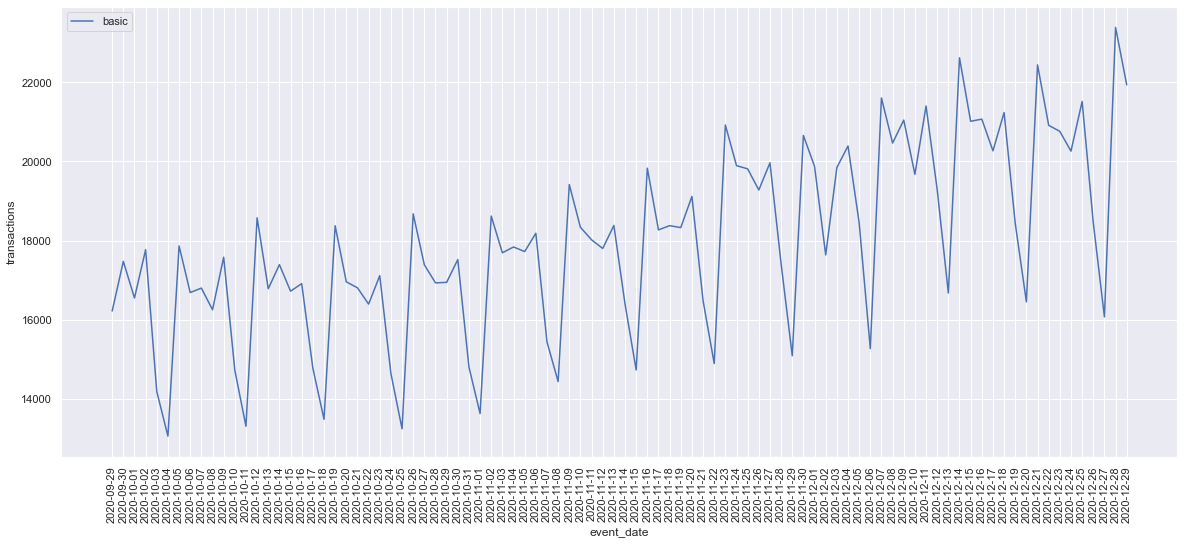

In [236]:
sns.set(rc={'figure.figsize':(20,8.27)})
#sns.lineplot(x='event_date', y='transactions', data = full_aggr_df, label='total')
sns.lineplot(x='event_date', y='transactions', data = full_aggr_df, label = 'total_transactions')
#sns.lineplot(x='event_date', y='adv_tr', data = full_aggr_df, label='advanced')
plt.xticks(tr_by_date['event_date'], rotation = 90)
plt.legend()
plt.show()

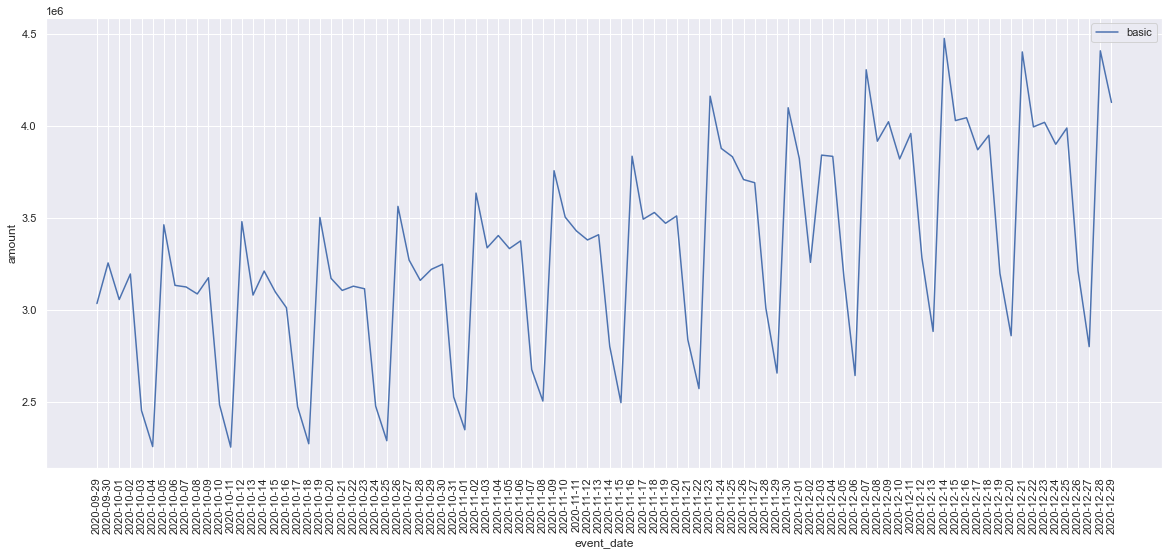

In [237]:
sns.set(rc={'figure.figsize':(20,8.27)})
#sns.lineplot(x='event_date', y='transactions', data = full_aggr_df, label='total')
sns.lineplot(x='event_date', y='amount', data = full_aggr_df, label = 'total_amount')
#sns.lineplot(x='event_date', y='adv_tr', data = full_aggr_df, label='advanced')
plt.xticks(tr_by_date['event_date'], rotation = 90)
plt.legend()
plt.show()

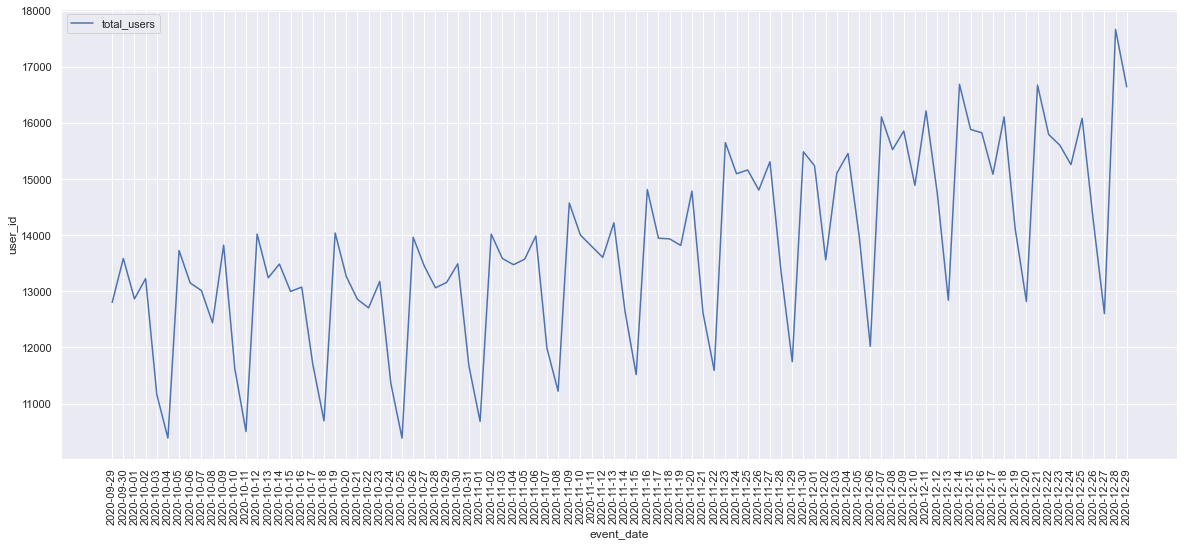

In [238]:
sns.set(rc={'figure.figsize':(20,8.27)})
#sns.lineplot(x='event_date', y='transactions', data = full_aggr_df, label='total')
sns.lineplot(x='event_date', y='user_id', data = full_aggr_df, label = 'total_users')
#sns.lineplot(x='event_date', y='adv_tr', data = full_aggr_df, label='advanced')
plt.xticks(tr_by_date['event_date'], rotation = 90)
plt.legend()
plt.show()

Сгруппируем метрики до недели и посомтрим на динамику. Сезонность убрали (на первой и последней неделе данные неполные)

In [239]:
basic_1_week = df[df['product']=='basic'].groupby(by='week_num').sum()[['amount', 'transactions']].reset_index()
basic_1_week.columns = ['week_num','basic_amount', 'basic_tr']

basic_2_week = df[df['product']=='basic'].groupby(by='week_num')['user_id'].nunique().reset_index()
basic_2_week.columns = ['week_num','basic_users']

basic_week = pd.merge(basic_1_week, basic_2_week, how='inner', on='week_num')

adv_1_week = df[df['product']=='advanced'].groupby(by='week_num').sum()[['amount', 'transactions']].reset_index()
adv_1_week.columns = ['week_num','adv_amount', 'adv_tr']

adv_2_week = df[df['product']=='advanced'].groupby(by='week_num')['user_id'].nunique().reset_index()
adv_2_week.columns = ['week_num','adv_users']

adv_week = pd.merge(adv_1_week, adv_2_week, how='inner', on='week_num')

sums_by_date_week = pd.DataFrame(df.groupby(by = 'week_num').sum()[['transactions', 'amount']]).reset_index()
cnt_by_date_week = pd.DataFrame(df.groupby(by = 'week_num')['user_id'].nunique()).reset_index()

full_aggr_df_week = pd.merge(sums_by_date_week, cnt_by_date_week, how = 'inner', on = 'week_num')
full_aggr_df_week['avg_transaction'] = full_aggr_df_week['amount']/full_aggr_df_week['transactions']
full_aggr_df_week['arppu'] = full_aggr_df_week['amount']/full_aggr_df_week['user_id']

#full_aggr_df_week = pd.merge(sums_by_date, cnt_by_date, how = 'inner', on = 'event_date')
full_aggr_df_week = pd.merge(full_aggr_df_week, basic_week, how = 'inner', on = 'week_num')
full_aggr_df_week = pd.merge(full_aggr_df_week, adv_week, how = 'inner', on = 'week_num')

full_aggr_df_week['adv_share'] = full_aggr_df_week['adv_users']/full_aggr_df_week['user_id']
full_aggr_df_week['basic_share'] = full_aggr_df_week['basic_users']/full_aggr_df_week['user_id']
full_aggr_df_week.head()

,week_num,transactions,amount,user_id,avg_transaction,arppu,basic_amount,basic_tr,basic_users,adv_amount,adv_tr,adv_users,adv_share,basic_share
0,40,95247.0,17244409.0,54698,181.049366,315.265805,9504576.0,74453.0,43634,7739833.0,20794.0,12115,0.221489,0.797726
1,41,113199.0,20713994.0,62585,182.987429,330.973780,11144020.0,87803.0,49908,9569974.0,25396.0,13971,0.223232,0.797443
2,42,114631.0,20619844.0,62910,179.880172,327.767350,11253667.0,89608.0,50477,9366177.0,25023.0,13770,0.218884,0.802368
3,43,113521.0,20783415.0,61613,183.079915,337.321913,11139408.0,88150.0,49357,9644007.0,25371.0,13539,0.219743,0.801081
4,44,115880.0,21332777.0,62309,184.093692,342.370717,11549596.0,90526.0,50190,9783181.0,25354.0,13390,0.214897,0.805502


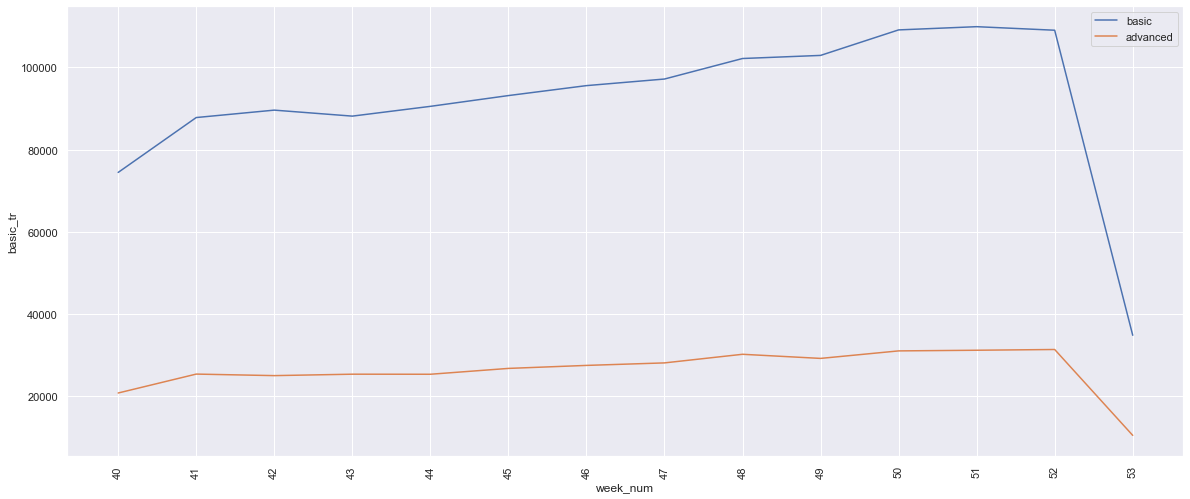

In [241]:
sns.set(rc={'figure.figsize':(20,8.27)})
#sns.lineplot(x='event_date', y='transactions', data = full_aggr_df, label='total')
sns.lineplot(x='week_num', y='basic_tr', data = full_aggr_df_week, label = 'basic')
sns.lineplot(x='week_num', y='adv_tr', data = full_aggr_df_week, label='advanced')
plt.xticks(full_aggr_df_week['week_num'], rotation = 90)
plt.legend()
plt.show()

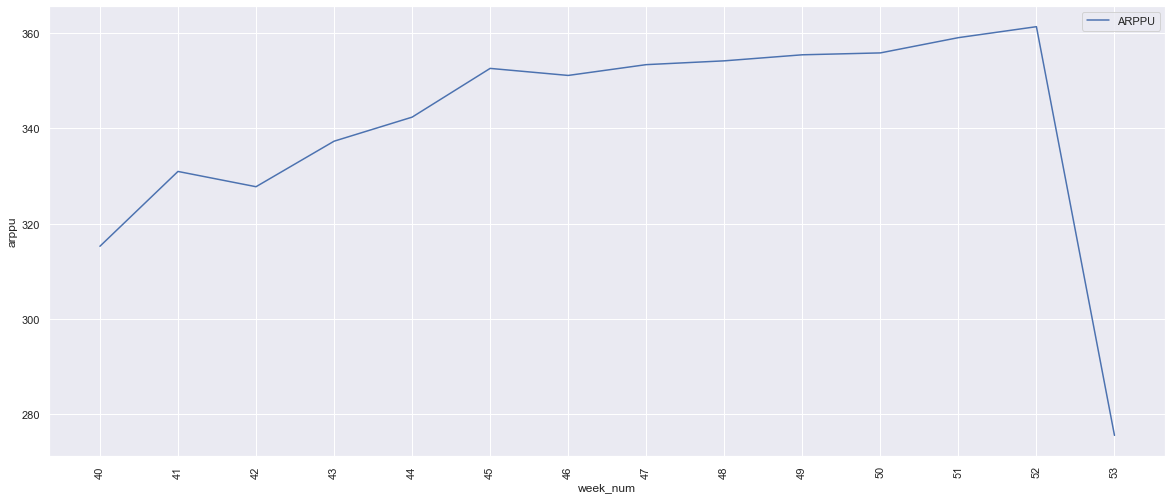

In [244]:
sns.set(rc={'figure.figsize':(20,8.27)})
#sns.lineplot(x='event_date', y='transactions', data = full_aggr_df, label='total')
sns.lineplot(x='week_num', y='arppu', data = full_aggr_df_week, label = 'ARPPU')
#sns.lineplot(x='event_date', y='adv_tr', data = full_aggr_df, label='advanced')
plt.xticks(full_aggr_df_week['week_num'], rotation = 90)
plt.legend()
plt.show()

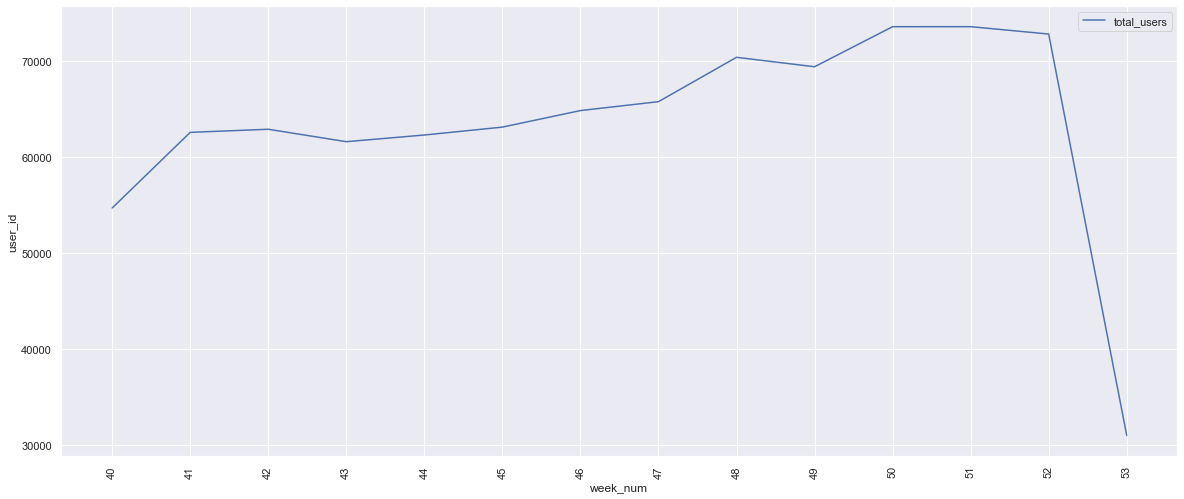

In [242]:
sns.set(rc={'figure.figsize':(20,8.27)})
#sns.lineplot(x='event_date', y='transactions', data = full_aggr_df, label='total')
sns.lineplot(x='week_num', y='user_id', data = full_aggr_df_week, label = 'total_users')
#sns.lineplot(x='week_num', y='adv_tr', data = full_aggr_df_week, label='advanced')
plt.xticks(full_aggr_df_week['week_num'], rotation = 90)
plt.legend()
plt.show()

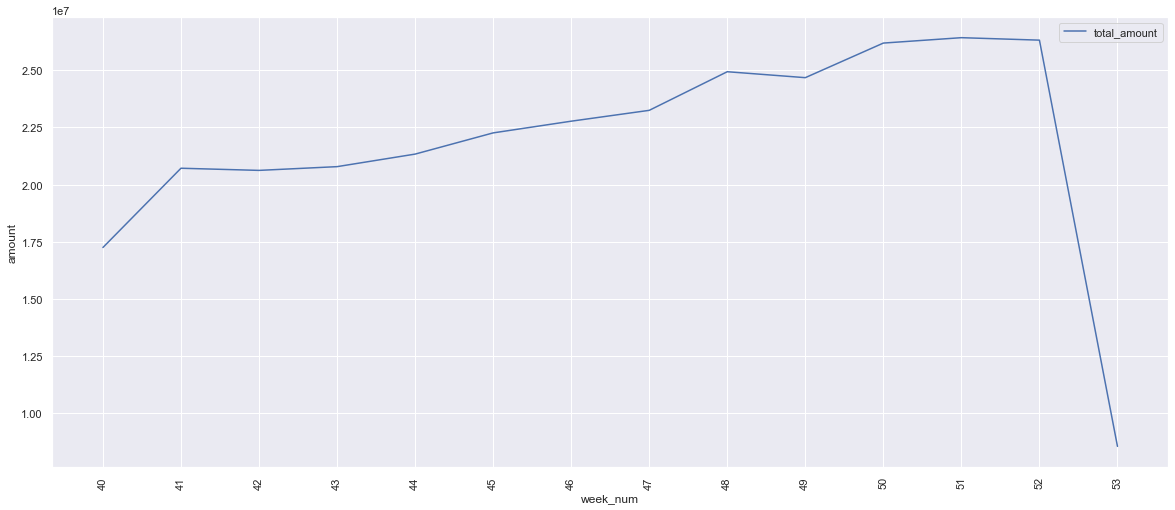

In [256]:
sns.set(rc={'figure.figsize':(20,8.27)})
#sns.lineplot(x='event_date', y='transactions', data = full_aggr_df, label='total')
sns.lineplot(x='week_num', y='amount', data = full_aggr_df_week, label = 'total_amount')
#sns.lineplot(x='week_num', y='adv_tr', data = full_aggr_df_week, label='advanced')
plt.xticks(full_aggr_df_week['week_num'], rotation = 90)
plt.legend()
plt.show()

Посмотрим на распределение метрик:

Выручка с пользователя на неделю имеет очень большое стандартное отклонение - можем ошибиться в выводах -  не будем брать эту метрику

344.38 916.95 110640.0 8.0


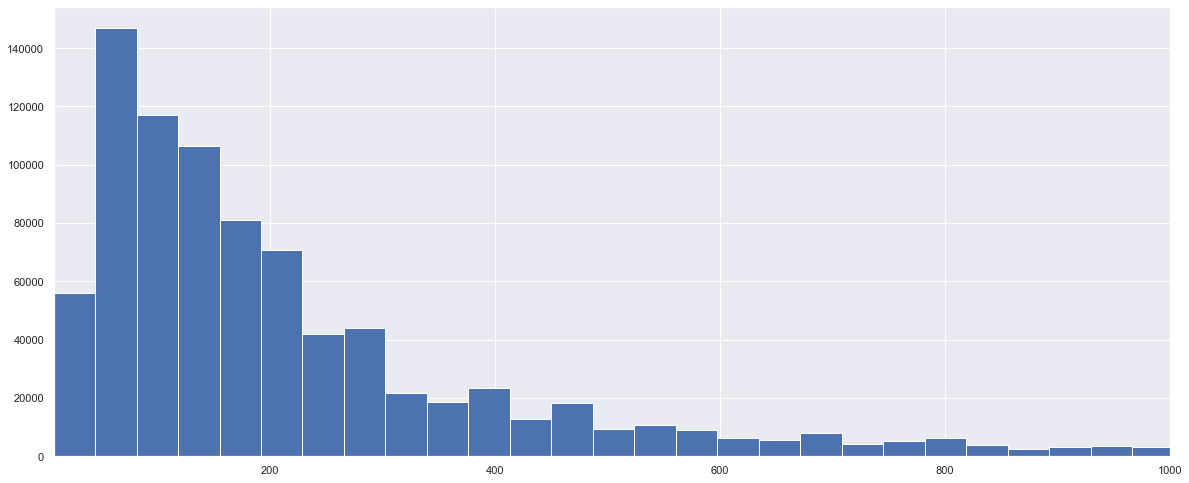

In [251]:
x = df.groupby(by=['user_id', 'week_num']).sum().reset_index()['amount']
#x = full_aggr_df_week['amount']
print(np.round(np.mean(x),2), np.round(np.std(x),2), np.round(np.max(x),2), np.round(np.min(x),2))
plt.xlim([8,1000])
plt.hist(x, bins=3000)#['amount'].reset_index()
#plt.xticks(np.arange(8, 1000, 10), rotation = 90)
plt.show()

В основном транзачат по одному разу в неделю, метрика будет не очень чувствительной - не будем ее брать

1.86 3.62 784 1


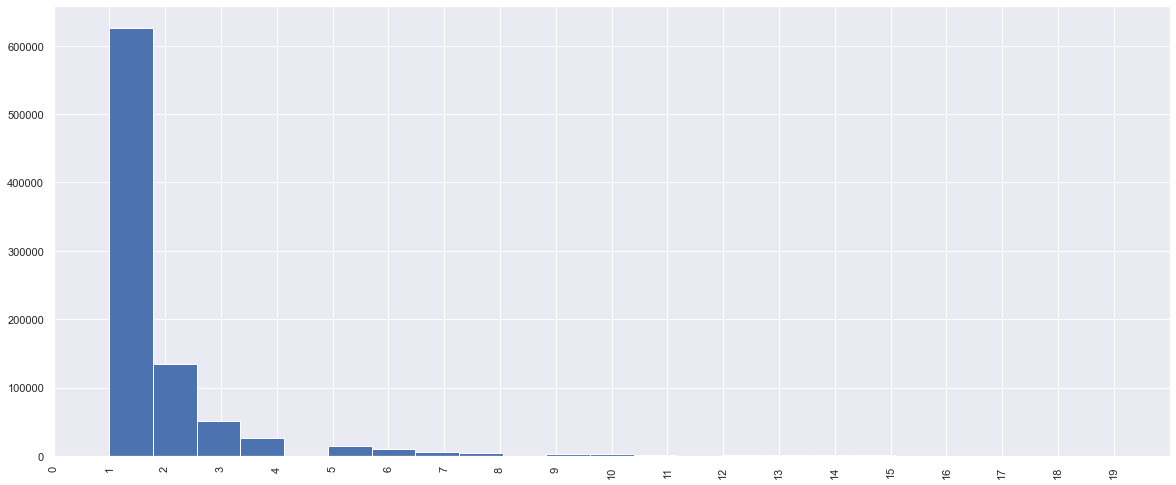

In [254]:
x = df.groupby(by=['user_id', 'week_num']).sum().reset_index()['transactions']
print(np.round(np.mean(x),2), np.round(np.std(x),2), np.round(np.max(x),2), np.round(np.min(x),2))
plt.xlim([0,20])
plt.hist(x[x>0], bins=1000)#['amount'].reset_index()
plt.xticks(np.arange(0,20), rotation = 90)
plt.show()

ARPPU недельный напоминает распределение хи-квадрат
Относительно небольшой разброс - оставим эту метрику

173.58 166.79 1869.0 8.0


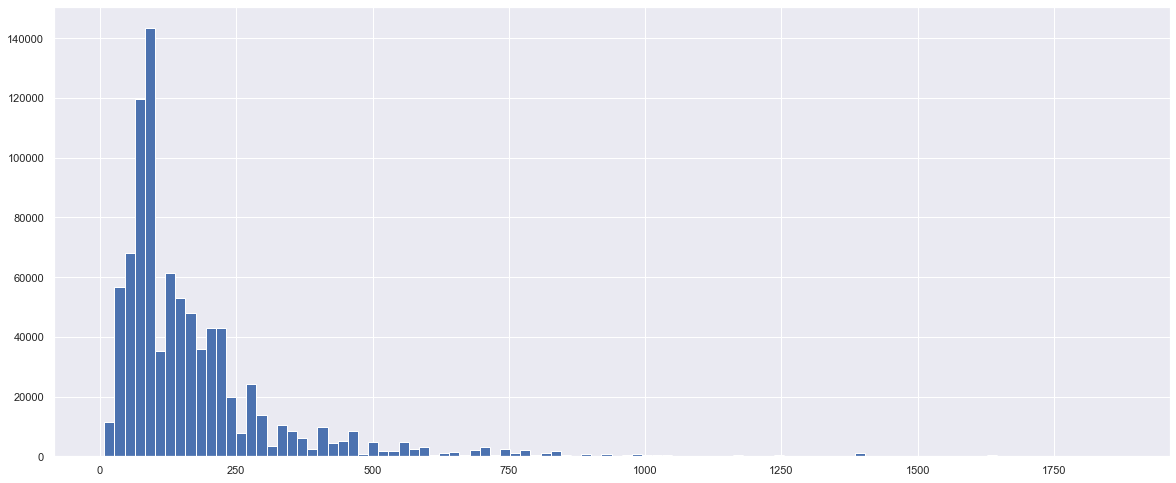

In [257]:
t = df.groupby(by=['user_id', 'week_num']).sum().reset_index()
x = t['amount']/t['transactions']
print(np.round(np.mean(x),2), np.round(np.std(x),2), np.round(np.max(x),2), np.round(np.min(x),2))
plt.hist(x, bins=100)
plt.show()

Еще раз метрики:

**Дополнительное информирование об эффективности услуг будет стимулировать их покупку:**
- кол-во транзакций на юзера за неделю (далее увидим, что у метрики недельная сезонность, берем неделю, чтобы убрать сезонность)  - ожидаю повышение
- кол-во уникальных платящих пользователей за неделю - ожидаю повышение
- ARPPU недельный- ожидаю повышение

**Повышение цены базового продукта должно стимулировать покупку продвинутого продукта:**
- доля платящих в тарифе advanced - повышение
- доля платящих в тарифе basic - понижение
- ARPPU недельный- повышение

Посчитаем для ARPPU

Ограничение по времени - квартал

Посмотрим, на сколько вырос ARPPU натурально, Для этого поделим 52 неделю на 41:

In [260]:
full_aggr_df_week[['week_num', 'arppu']]

,week_num,arppu
0,40,315.265805
1,41,330.973780
2,42,327.767350
3,43,337.321913
4,44,342.370717
5,45,352.604612
6,46,351.126415
7,47,353.391481
8,48,354.190396
9,49,355.459152


Натуральный рост без вмешательств за квартал - 9%

In [262]:
np.round(361.36148/330.973780, 2)

1.09

Пусть мы ожидаем uplift в 10%

In [270]:
#x1 = choose_date(df, datetime.datetime(2020,9, 29, 0, 0),92,1) #получаем необходимую подвыборку

from statsmodels.stats.power import tt_ind_solve_power
 
mean = 173.58
std = 166.79
 
alpha = 0.05
power = 0.8
result_effect = 0.1 # целевой размер относительного отклоенения исходной метрики
effect_size = (mean /std) * result_effect
 
    
sample_vol = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative = 'two-sided')    
print(sample_vol)#/df.shape[0])# получаем множитель того, во сколько раз необходимо изменить размер выборки


1450.3242960139762


В таком случае нам нужно собрать группы не менее чем по 1450 человека, чтоб провести эксперимент

Лучше всего провести два независимых эксперимента на две гипотезы, чтобы эффекты не смешивались